# JPX Growth Board Analysis

## Background

This analysis focuses on the growth board of JPX and will look at the valuation difference, price and fundamental performance of companies listed on the growth board vs the rest of the market and try to give suggestions on actions post IPO for a company that provides power bank services. We will also look at some comparable companies (Smart Charge, formerly known as [EN Monster](https://www.enmonster.com/)) listed elsewhere and see what implications can be drawn.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from typing import Union, Optional
import typing
import scipy.stats as stats
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [211]:
# read data from SQL
dbs = {'jpx_growth': {}, 'japan_indices': {}, 'jasdaq': {}}
for dbname, d in dbs.items():
    conn = sqlite3.connect(f'./jpx_analysis/sqldata/{dbname}.db')
    d['desc'] = pd.read_sql(sql='select * from desc', con=conn, index_col=['index'])
    d['market_data'] = pd.read_sql(sql='select * from market_data', con=conn, index_col=['field', 'ticker'])
    d['fundamental_data'] = pd.read_sql(sql='select * from fundamental_data', con=conn, index_col=['level_0', 'level_1'])

## 1. Compare growth board valuation vs the overall market

### 1.1 Valuation comparion

We can first look at the overall valuation on the growth board vs the overall market in Japan. 

As there are many unprofitable companies on the growth board, given the early stage nature, apart from the price/earnings ratios, we also look at the price/sales and price/book.

Ideally we would also look at FCF yield and EV/EBITDA, but these were not available for the Nikkei 225.


As figure 1 shows, growth board stocks in general are a order of magnitude more expensive compared with the rest of the market, and is also much more expensive than the growth‑oriented JASDAQ section. This is in part due to the early stage nature of the companies on the board, which tend to have faster growth and depressed margins due to investment in growth.

- Valuation trends tend to be similar, but growth board tend to be a bit more volatile and have seen more pull back recently.

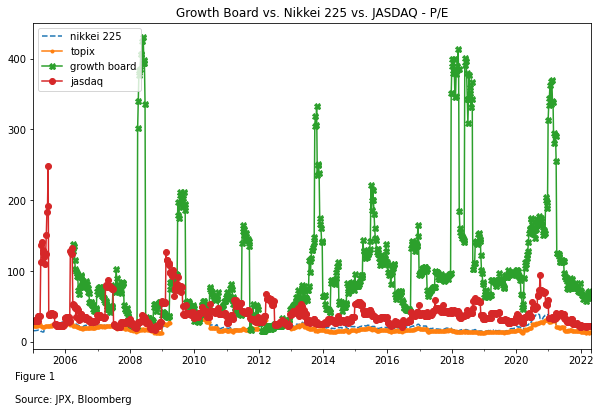

In [385]:
# PE ratio comparison
f, ax = plt.subplots(1, figsize=(10, 6))
chartdata1 = dbs.get('japan_indices').get('market_data').copy(deep=True)
chartdata2 = dbs.get('jpx_growth').get('market_data').copy(deep=True)
chartdata3 = dbs.get('jasdaq').get('market_data').copy(deep=True)
chartdata1.columns = chartdata1.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata2.columns = chartdata2.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata3.columns = chartdata3.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata1.loc[('pe_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
chartdata1.loc[('pe_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='topix')
chartdata2.loc['pe_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='X-', label='growth board')
chartdata3.loc['pe_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='linear', title='Growth Board vs. Nikkei 225 vs. JASDAQ - P/E')
f.text(0.1,0, "Figure 1\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
plt.show()

Looking at both P/S and P/B, the growth board overall is about 10x more expensive than the rest of the market.

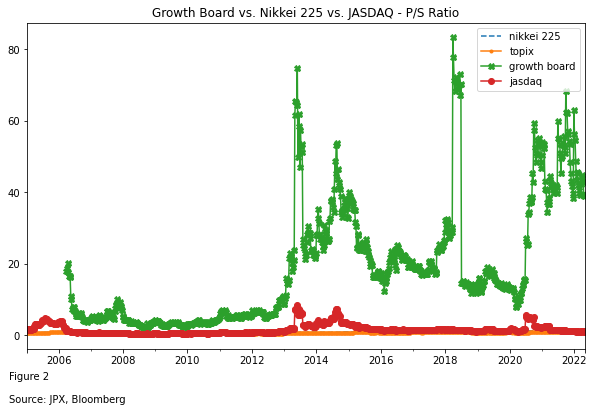

In [384]:
# PS ratio comparison
f, ax = plt.subplots(1, figsize=(10, 6))

chartdata1.loc[('px_to_sales_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
chartdata1.loc[('px_to_sales_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='topix')
chartdata2.loc['px_to_sales_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='X-', label='growth board')
chartdata3.loc['px_to_sales_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='linear', title='Growth Board vs. Nikkei 225 vs. JASDAQ - P/S Ratio')
f.text(0.1,0, "Figure 2\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
ax.legend()
plt.show()

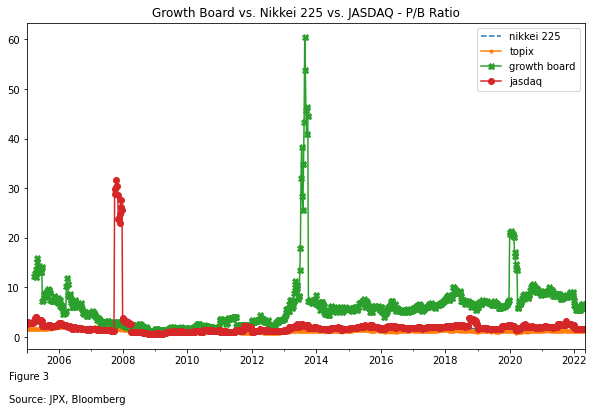

In [386]:
# PB ratio comparison
f, ax = plt.subplots(1, figsize=(10, 6))

chartdata1.loc[('px_to_book_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
chartdata1.loc[('px_to_book_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='topix')
chartdata2.loc['px_to_book_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='X-', label='growth board')
chartdata3.loc['px_to_book_ratio', dt.date(2005, 1, 1):].mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='linear', title='Growth Board vs. Nikkei 225 vs. JASDAQ - P/B Ratio')
f.text(0.1,0, "Figure 3\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
ax.legend()
plt.show()

If we control for only the electrics appliance & internet services sector, the valuation gap continues to hold. I could only get the MSCI IT sector index that represent, so the meaningful comparison would be to compare it with the IT services, hardware, electronics, and semiconductor sectors on the growth board. 

- Also worth noting that there has not been a pullback in valuation recently in the IT sector on the growth board, contrary to the other indices.

In [225]:
jpx_g_it_mask = dbs.get('jpx_growth').get('desc').gics_industry_name.isin([ 'IT Services', 
    'Semiconductors & Semiconductor', 'Electronic Equipment, Instrume',
    'Communications Equipment', 'Technology Hardware, Storage &']).values
jasdaq_it_mask = dbs.get('jasdaq').get('desc').gics_industry_name.isin([ 'IT Services', 
    'Semiconductors & Semiconductor', 'Electronic Equipment, Instrume',
    'Communications Equipment', 'Technology Hardware, Storage &']).values

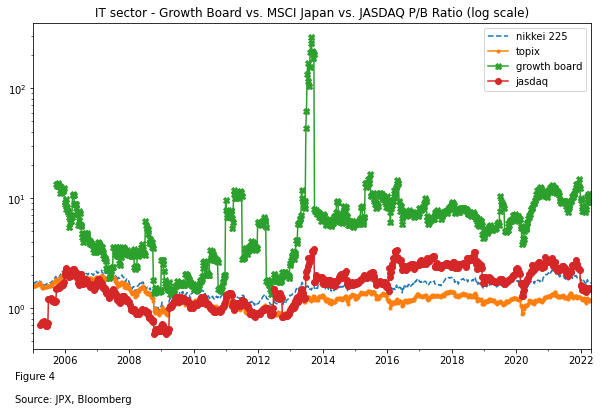

In [228]:
# PB ratio comparison - IT 
f, ax = plt.subplots(1, figsize=(10, 6))

chartdata1.loc[('px_to_book_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
chartdata1.loc[('px_to_book_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='topix')
chartdata2.loc['px_to_book_ratio', dt.date(2005, 1, 1):].loc[jpx_g_it_mask].mean(axis=0).plot(ax=ax, style='X-', label='growth board')
chartdata3.loc['px_to_book_ratio', dt.date(2005, 1, 1):].loc[jasdaq_it_mask].mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='log', title='IT sector - Growth Board vs. MSCI Japan vs. JASDAQ P/B Ratio (log scale)')
f.text(0.1,0, "Figure 4\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
ax.legend()
plt.show()

### 1.3 Difference in fundamentals

As figure 4 shows, the growth board has a faster growth rate than JASDAQ, as expected, but growth in new listings in the recent 2 years have been easing off.

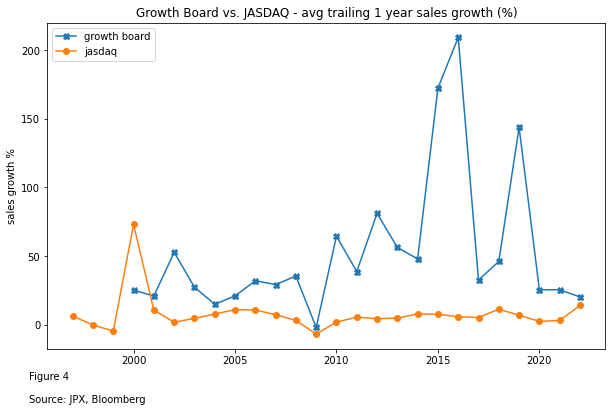

In [7]:
# fundamental data comparison - ebitda margin
f, ax = plt.subplots(1, figsize=(10, 6))
# chartdata1 = dbs.get('japan_indices').get('fundamental_data').copy(deep=True)
chartdata2 = dbs.get('jpx_growth').get('fundamental_data').copy(deep=True)
chartdata3 = dbs.get('jasdaq').get('fundamental_data').copy(deep=True)
# chartdata1.columns = chartdata1.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata2.columns = chartdata2.columns.astype(int)
chartdata3.columns = chartdata3.columns.astype(int)
# chartdata1.loc[('pe_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
# chartdata1.loc[('pe_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='japanese 225')
chartdata2.query('level_1=="trailing_12m_sales_growth"').mean(axis=0).plot(ax=ax, style='X-', label='growth board')
mean1, std1 = chartdata2.query('level_1=="trailing_12m_sales_growth"').mean(axis=0), chartdata2.query('level_1=="trailing_12m_sales_growth"').std(axis=0)
# ax.fill_between(x=mean1.index, y1=mean1, y2=mean1 + std1, label = 'growth board +1sd', color='lightgray', alpha=0.3)
chartdata3.query('level_1=="trailing_12m_sales_growth"').mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='linear', title='Growth Board vs. JASDAQ - avg trailing 1 year sales growth (%)', ylabel='sales growth %')
f.text(0.1,0, "Figure 4\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
plt.show()

Looking at the margins, we can see that the growth board stocks are generally loss making even on the EBITDA line. This partially explains the high average P/E. 

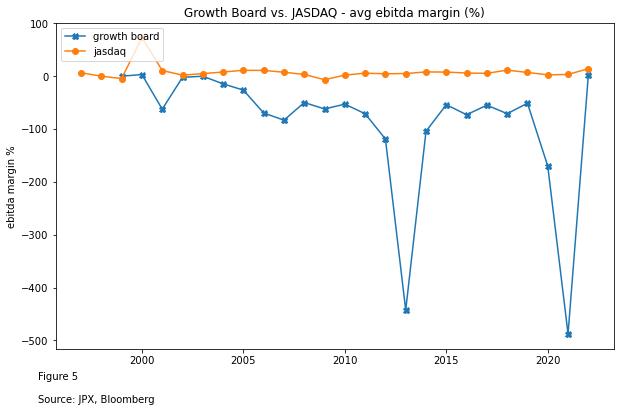

In [8]:
# fundamental data comparison - ebitda margin
f, ax = plt.subplots(1, figsize=(10, 6))
# chartdata1 = dbs.get('japan_indices').get('fundamental_data').copy(deep=True)
chartdata2 = dbs.get('jpx_growth').get('fundamental_data').copy(deep=True)
chartdata3 = dbs.get('jasdaq').get('fundamental_data').copy(deep=True)
# chartdata1.columns = chartdata1.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata2.columns = chartdata2.columns.astype(int)
chartdata3.columns = chartdata3.columns.astype(int)
# chartdata1.loc[('pe_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
# chartdata1.loc[('pe_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='japanese 225')
chartdata2.query('level_1=="ebitda_margin"').mean(axis=0).plot(ax=ax, style='X-', label='growth board')
mean1, std1 = chartdata2.query('level_1=="ebitda_margin"').mean(axis=0), chartdata2.query('level_1=="trailing_12m_sales_growth"').std(axis=0)
# ax.fill_between(x=mean1.index, y1=mean1, y2=mean1 + std1, label = 'growth board +1sd', color='lightgray', alpha=0.3)
chartdata3.query('level_1=="trailing_12m_sales_growth"').mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='linear', title='Growth Board vs. JASDAQ - avg ebitda margin (%)', ylabel='ebitda margin %')
f.text(0.1,0, "Figure 5\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
plt.show()

We can also look at gross margin as ebitda margin tends to be distorted by a few very loss making companies. These could be pharmaceutical companies that have a high R&D cost but did not have a meaningful revenue yet. 

As the chart below shows, growth board on average actually has a better gross margin than JASDAQ. This makes sense given the technology-focus on the board. 

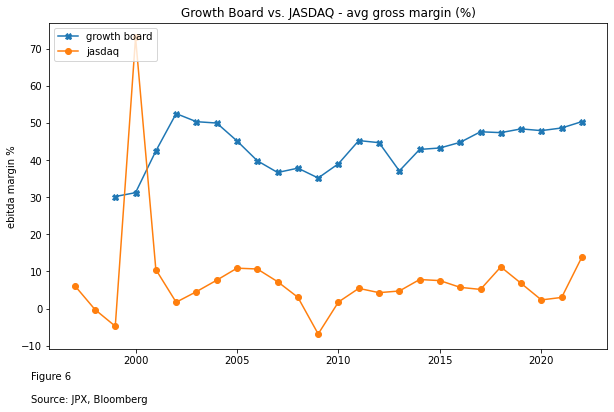

In [475]:
# fundamental data comparison - ebitda margin
f, ax = plt.subplots(1, figsize=(10, 6))
# chartdata1 = dbs.get('japan_indices').get('fundamental_data').copy(deep=True)
chartdata2 = dbs.get('jpx_growth').get('fundamental_data').copy(deep=True)
chartdata3 = dbs.get('jasdaq').get('fundamental_data').copy(deep=True)
# chartdata1.columns = chartdata1.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata2.columns = chartdata2.columns.astype(int)
chartdata3.columns = chartdata3.columns.astype(int)
# chartdata1.loc[('pe_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
# chartdata1.loc[('pe_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='japanese 225')
chartdata2.query('level_1=="gross_margin"').mean(axis=0).plot(ax=ax, style='X-', label='growth board')
mean1, std1 = chartdata2.query('level_1=="gross_margin"').mean(axis=0), chartdata2.query('level_1=="trailing_12m_sales_growth"').std(axis=0)
# ax.fill_between(x=mean1.index, y1=mean1, y2=mean1 + std1, label = 'growth board +1sd', color='lightgray', alpha=0.3)
chartdata3.query('level_1=="trailing_12m_sales_growth"').mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='linear', title='Growth Board vs. JASDAQ - avg gross margin (%)', ylabel='ebitda margin %')
f.text(0.1,0, "Figure 6\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
plt.show()

Slightly surprisingly though, the average market cap on the growth board is actually higher than the JASDAQ, between JPY10-20bn. 

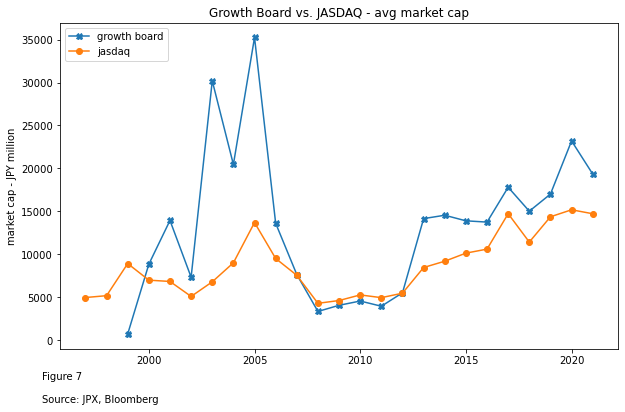

In [457]:
# fundamental data comparison - ebitda margin
f, ax = plt.subplots(1, figsize=(10, 6))
# chartdata1 = dbs.get('japan_indices').get('fundamental_data').copy(deep=True)
chartdata2 = dbs.get('jpx_growth').get('fundamental_data').copy(deep=True)
chartdata3 = dbs.get('jasdaq').get('fundamental_data').copy(deep=True)
# chartdata1.columns = chartdata1.columns.to_series().apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
chartdata2.columns = chartdata2.columns.astype(int)
chartdata3.columns = chartdata3.columns.astype(int)
# chartdata1.loc[('pe_ratio', 'nky index'), dt.date(2005, 1, 1):].plot(ax=ax, style='--', label='nikkei 225')
# chartdata1.loc[('pe_ratio', 'tpx index'), dt.date(2005, 1, 1):].plot(ax=ax, style='.-', label='japanese 225')
chartdata2.query('level_1=="cur_mkt_cap"').mean(axis=0).plot(ax=ax, style='X-', label='growth board')
# ax.fill_between(x=mean1.index, y1=mean1, y2=mean1 + std1, label = 'growth board +1sd', color='lightgray', alpha=0.3)
chartdata3.query('level_1=="cur_mkt_cap"').mean(axis=0).plot(ax=ax, style='o-', label='jasdaq')

ax.set(yscale='linear', title='Growth Board vs. JASDAQ - avg market cap', ylabel='market cap - JPY million')
f.text(0.1,0, "Figure 7\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
plt.show()

## 2. Performance since IPO

We can now look at the performance since IPO. We will look at this through the following angles:
1) General performance since IPO;
2) Performance by sector;
3) General market condiction, interest rates, and company characteristics and their impact to IPO performance;

In [10]:
class IPOAnalysis:
    # get start date
    def __init__(self, dbname, datetime_format='%Y-%m-%d'):
        self.dbname = dbname
        self.desc = dbs.get(dbname).get('desc')
        self.desc.eqy_init_po_dt = self.desc.eqy_init_po_dt.apply(lambda x: 
            dt.datetime.strptime(x, datetime_format) if isinstance(x, str) else x)
        self.fundamental_data = dbs.get(dbname).get('fundamental_data')
        if not self.fundamental_data.columns.dtype in ['int32', 'int64']:
            try:
                self.fundamental_data.columns = self.fundamental_data.columns.astype(int)
            except ValueError:
                self.fundamental_data.column = self.fundamental_data.columns.to_series().apply(lambda x: int(x) if x.isdigit() else np.nan)
        self.market_data = dbs.get(dbname).get('market_data')
        if not self.market_data.columns.dtype in ['datetime64[ns]', '<M8[ns]']:
            try:
                self.market_data.columns = self.market_data.columns.astype('datetime64[ns]')
            except ValueError:
                self.market_data.columns = self.market_data.columns.to_series().apply(lambda x: dt.datetime.strptime(x, datetime_format))

    def standardize_by_start(self, field: str='pe_ratio', use_market_data: bool=True, 
        listing_year: Union[list, None]=None):
        """pull every ticker back to the IPO date"""
        desc = self.desc.copy(deep=True).reset_index()
        if use_market_data:
            data = self.market_data.copy(deep=True).T
        else:
            data = self.fundamental_data.copy(deep=True).swaplevel(0, 1).sort_index().T
        if listing_year:
            desc = desc.loc[desc.eqy_init_po_dt.apply(lambda d: d.year).isin(listing_year).values, :]
        if len(desc):
            start_dates = dict(desc.loc[:, ['index', 'eqy_init_po_dt']].values)
            ls = []
            for ticker, s in data.loc[:, field].iteritems():
                if isinstance(start_dates.get(ticker), dt.date):
                    if use_market_data:
                        temp = s.loc[start_dates.get(ticker):].dropna()
                    else:
                        temp = s.loc[start_dates.get(ticker).year:].dropna()
                    temp.index = range(len(temp))
                    temp.name = ticker
                    ls.append(temp.to_frame())
            return start_dates, pd.concat([i.T for i in ls]).T
    def get_change_since_ipo(self, field='pe_ratio', sector='Electronic Equipment, Instrume', listing_year=None):
        """get the change since IPO
        :param field: bbg field to be passed to standardize_by_start(), 
        :param sector: if pass 'all', will not be filtered"""
        desc = self.desc.copy(deep=True).reset_index()
        desc.reset_index(inplace=True)
        if sector == 'all': tickers = desc.loc[:, 'index']
        else: tickers = desc.loc[desc.gics_industry_name == sector, 'index'].values
        data = self.standardize_by_start(field=field, listing_year=listing_year)[1]
        tickers = data.columns.intersection(tickers)
        data = data.loc[:, tickers]
        if field != 'px_last': return data - data.iloc[0, :]
        else: 
            ipo_px = dict(desc.loc[:, ['index', 'eqy_init_po_sh_px']].values)
            return data / data.columns.to_series().map(ipo_px).values
    def plot_change_since_ipo(self, field='pe_ratio', sector='Electronic Equipment, Instrume',
        figsize: tuple=(10, 6), xlim=(1, 365), ylim=(-50, 50), listing_year=None):
        data = self.get_change_since_ipo(field=field, sector=sector, listing_year=listing_year)
        n = data.shape[1]
        f, ax = plt.subplots(1, figsize=figsize)
        mean = data.mean(axis=1)
        std = data.std(axis=1)
        ax.plot(mean, label='mean')
        ax.fill_between(x=data.index, y1=mean, y2=mean + std, label = '+1sd', color='lightgray', alpha=0.3)
        ax.fill_between(x=data.index, y1=mean, y2=mean - std, label = '-1sd', color='lightgray', alpha=0.3)
        ax.fill_between(x=data.index, y1=mean, y2=mean + 0.5*std, label = '+0.5sd', color='lightgray', alpha=0.6)
        ax.fill_between(x=data.index, y1=mean, y2=mean - 0.5*std, label = '-0.5sd', color='lightgray', alpha=0.6)
        ax.legend()
        ax.set(title=f"{field} since IPO - listed in {listing_year}\n{sector} sector(s); n={n}", xlim=xlim, ylim=ylim)
        return f

In [11]:
# JPX growth board analysis
ia = IPOAnalysis('jpx_growth')
start_dates, standardized = ia.standardize_by_start(use_market_data=False, field='sales_rev_turn')

Looking at the share price performance on the growth board, we can observe a few interesting trends, some of which are generally true with IPOs:

1) After 2013, the average IPOs rise more than 25% from the issue price.

2) It seems like the secondary market is fairly efficient at pricing IPOs, with share prices stablizing after IPOs. The average share price performance 1/4/12 weeks after IPO don't differ that much from the IPO price. 

3) Except for 2019 which was an unusual year (trade war, macro shocks), share price after a year almost always to IPO levels on average. 

4) There are a few bad years such as 2015 when IPOs performed poorly and generally did not rise above the issue prices. Given the macro uncertainties 2022 is likely going to be such a year. 

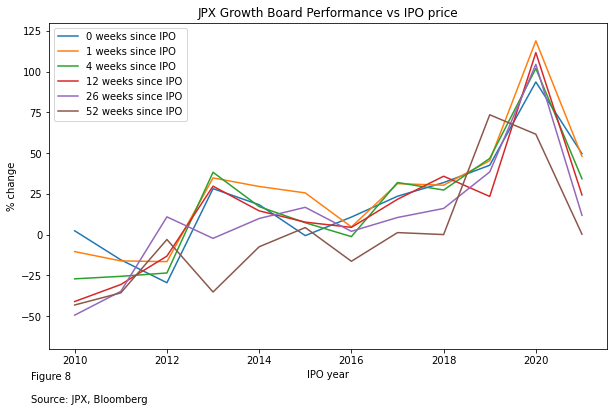

In [12]:
ipo_px_chg = ia.get_change_since_ipo(field='px_last', sector='all', listing_year=list(range(2001, 2022)))
ipo_px_chg.columns = ipo_px_chg.columns.map(start_dates)
ipo_px_chg = ipo_px_chg.T.sort_index()
ipo_px_chg.loc[:, "year"] = ipo_px_chg.index.to_series().apply(lambda d: d.year)
ipo_px_chg.loc[:, "quarter"] = ipo_px_chg.index.to_series().apply(lambda d: d.month // 3)
ipo_px_chg.loc[:, "month"] = ipo_px_chg.index.to_series().apply(lambda d: d.month)
ipo_px_chg.loc[:, "week"] = ipo_px_chg.index.to_series().apply(lambda d: d.day // 7)

f, ax = plt.subplots(1, figsize=(10, 8))
plotdata = ipo_px_chg.groupby(['year']).mean().query("year>=2010")*100 - 100
for day_since_ipo in (0, 1, 4, 12, 26, 52):
    plotdata.iloc[:, day_since_ipo].plot(kind='line',
        figsize=(10, 6), ax=ax, ylim=(-70, 130), label=f"{day_since_ipo} weeks since IPO")
ax.set(yscale='linear', ylabel='% change', xlabel='IPO year', title='JPX Growth Board Performance vs IPO price')
f.text(0.1,0, "Figure 8\n\nSource: JPX, Bloomberg")
ax.legend(loc='upper left')
ax.legend()
plt.show()

### 2.1 An analysis into the factors driving IPO performance

We can now look at the IPOs and try to predict IPO price, incorporating the various macro and market data as factors contributing to the performance. 

We are NOT going to look at 'similar' companies and assume this IPO to be similar, due to a few reasons:

1) There are virtually not similar company;

2) As we will see below, the most important factor is actually not the company's business, but how it's valued and the market conditions for IPOs. Over a longer horizon, stock performance will revert back to trend with its fundamentals, but IPOs don't usually reflect the underlying fundamentals;

3) Market condition, valuation, and many other random variables could affect the IPO performance. 

As a result, we need to look at the many factors deciding IPO performance, while also acknolwedging that IPO performance has a large random/stochastic component to it.

In [ ]:
# create tabular data containing all the features

In [326]:
# create training data

# concert indices data columns to date
indice_mkt_data = dbs.get('japan_indices').get('market_data').copy(deep=True)
indice_mkt_data.columns = indice_mkt_data.columns.to_series().apply(lambda d: dt.datetime.strptime(d, '%Y-%m-%d'))

train_data = ia.desc.copy(deep=True).reset_index().set_index(['index', 'short_name', 'cie_des'], drop=True)

train_data.loc[:, 'ipo_ps'] = train_data.eqy_init_po_sh_px / \
    train_data.index.get_level_values('index').to_series().map(
        dict(ia.standardize_by_start(use_market_data=False, field='revenue_per_sh')[1].iloc[0, ]))
train_data.loc[:, 'ipo_pe'] = train_data.eqy_init_po_sh_px / \
    train_data.index.get_level_values('index').to_series().map(
        dict(ia.standardize_by_start(use_market_data=False, field='is_eps')[1].iloc[0, ]))
train_data.loc[:, 'ipo_pb'] = train_data.eqy_init_po_sh_px / \
    train_data.index.get_level_values('index').to_series().map(
        dict(ia.standardize_by_start(use_market_data=False, field='book_val_per_sh')[1].iloc[0, ]))
for fld in ('ebitda_margin', 'ebit_margin', 'gross_margin', 'trailing_12m_sales_growth', 'sales_3yr_avg_growth', 'sales_rev_turn'):
    train_data.loc[:, fld] = train_data.index.get_level_values('index').to_series().map(
            dict(ia.standardize_by_start(use_market_data=False, field=fld)[1].iloc[0, ])).values
train_data.loc[:, 'listing_mkt_cap'] = train_data.index.get_level_values('index').to_series().map(
            dict(ia.standardize_by_start(use_market_data=True, field='cur_mkt_cap')[1].iloc[0, ])).values

train_data.loc[("target company", 'Electronic Equipment & Instrum', 'This is the company we are trying to do prediction for'), :] \
    = ['Electronic Equipment & Instrum', 
    'Electronic Equipment & Instrum', 
    np.datetime64(dt.date(2022, 5, 8)), 50000,
    20, -100, 20, 25, 1, 85, 40, 50, 1000, 20000]

for ind in ['tpx index', 'nky index', 'usgg10yr index', 'jpy curncy']:
    for horizon in (1, 4, 12, 26, 52):
        train_data.loc[:, f"{ind}_chg_{horizon}wks"] = [(s.iloc[-1] - s.iloc[0])/s.iloc[0] if isinstance(s, pd.Series) else np.nan 
        for s in [indice_mkt_data.loc[('px_last', ind), (d - dt.timedelta(days=horizon * 7)):d] 
            if isinstance(d, pd.Timestamp) else np.nan for d in train_data.eqy_init_po_dt]]
train_data.drop('eqy_init_po_sh_px', axis=1, inplace=True)

In [276]:
def get_y(horizon: int=0):
    """get target for training
    :param horizon: number of weeks after IPO"""
    ipo_px_chg = ia.get_change_since_ipo(field='px_last', sector='all', listing_year=list(range(2001, 2022))) - 1
    return ipo_px_chg.iloc[horizon]

In [328]:
for horizon in (0, 1, 4, 12, 26, 52):
    y = get_y(horizon)
    train_data.loc[:, f'target_{horizon}weeks'] = train_data.index.get_level_values('index').to_series().map(dict(y)).values

In [329]:
# encode categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature_name, col in train_data.select_dtypes(object).iteritems():
    train_data.loc[:, f"{feature_name}_encoded"] = le.fit_transform(col)

In order to look at the factors affecting IPOs in JPX's growth board, we can first create a dataset containing the features we want about the company - sector, valuation, index performance before the IPO.

The created dataset looks like this (data is provided, I transposed the data to make it more viewable. This includes the first 5 rows and companies only as an example):

In [473]:
train_data.head().T.head().fillna('')

index,1400 JP Equity,1401 JP Equity,1431 JP Equity,1436 JP Equity,1447 JP Equity
short_name,RUDEN HD,MBS INC,LIB WORK CO LTD,FIT CORP,ITBOOK HOLDINGS
cie_des,"Ruden Holdings Co., Ltd. constructs and remodels buildings, apartments, and houses. The Company specializes in interior design reforms. Also, Ruden Holdings sells interior products and securities products.",mbs. inc. repairs and renovates outer walls and interiors for housings and buildings. The Company also provides consulting services on renovation work.,"Lib Work Co. Ltd. operates as a custom homebuilder. The Company designs, constructs, and sells single-family homes. Lib Work also renovates and remodels homes.","Fit Corporation builds homes. The Company builds and sells single family houses, apartments, prefabricated houses, and other buildings. Fit provides its services throughout Japan.","ITbook Holdings Co., LTD offers IT services. The Company provides IT and system procurement support, technology consulting, and other services. ITbook Holdings offers services in Japan."
gics_industry_name,Construction & Engineering,Household Durables,Real Estate Management & Devel,Independent Power and Renewabl,IT Services
gics_sub_industry_name,Construction & Engineering,Homebuilding,Real Estate Development,Independent Power Producers &,IT Consulting & Other Services
eqy_init_po_dt,2005-04-06 00:00:00,2005-04-26 00:00:00,2015-08-05 00:00:00,2016-03-11 00:00:00,
ipo_ps,21.093566,733.072665,3.452758,0.836822,
ipo_pe,-95.947804,7438.262422,98.674067,9.580778,


* Note category meanings 

- gics_industry is the GICS industry classification from S&P. 

- cie_des is the description of the company's main business.

- eqy_init_po_dt is the IPO date of the stock.

- ipo_pe/ps/pb are the valuations at IPO for the companies.

We have examined the IPO performance grouped by year, but we didn't look at the distribution of performance. We can now take a look:

- The mode is about 0% increase at IPO, which is a lot lower than the mean, which is generally positive as discussed above. This is due to the long tail towards the right skewing the distribution, meaning majority of the IPOs are actually flat.

- Shares tend to perform better at IPO date and within 1 week of IPO than afterwards. 

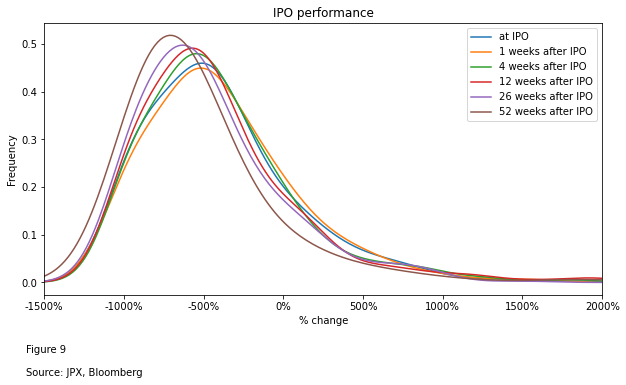

In [474]:
# plot distribution of IPO performance
import warnings
warnings.filterwarnings('ignore')

f, ax = plt.subplots(1, figsize=(10, 5))

train_data.target_0weeks.plot(kind='kde', ax=ax, label="at IPO")
for week in [1, 4, 12, 26, 52]:
    train_data.loc[:, f"target_{week}weeks"].plot(kind='kde', ax=ax, label=f"{week} weeks after IPO")
xticks = ax.get_xticks()
xticklabels = [f"{x*100:.0f}%" for x in xticks]
ax.set_xticklabels(labels=xticklabels)
ax.set(ylabel='Frequency', xlabel='% change', title='IPO performance', xlim=(-2, 5))
ax.legend(loc='upper right')
f.text(0.1,-0.1, "Figure 9\n\nSource: JPX, Bloomberg")
plt.show()

Let's first look at the correlation among different factors determining IPO performance. 

Table below summerizes factors' correlation with the price performance at and after IPO. Table is sorted in descending order by the IPO day performance. We can see that:

1) US interest rate change in the previous 4 and 12 weeks is positively correlated to IPO performance, and the 2 main indices in Japan, Nikkei 225 and TOPIX are both positively correlated with performance. These correlations tend to fade longer after the IPO (expected, known as alpha decay in quantitative trading). This basicaly means in a bull market, IPOs tend to do better, which is self explanatory. 

2) Only gross margin seemed positively correltated with IPO performance. Sales growth, ebitda margin nd ebit margin did not show much correlation - this could be due to extreme values in the dataset - earlier I have shown that in some years IPOs tend to have extremely loss making companies on the ebitda line. 

3) Valuation is negatively correlated with IPO performance. 

4) Sector has a weak correlation with performance (positive or negative doesn't matter, these are dummy variables). 

For example, usgg10yr index_chg_12wk (usgg10yr is the 10 year US govt bond, this is the trailing 12 weeks price change in US govt bond - see note below) has 15.28% correlation with the IPO same day performance and is the most positively correlated factor. On the other hand, ipo_pe, ipo_ps, and ipo_pb are the most negatively correlated factors - this makes sense as the most expensive IPOs generally tend not to perform very well on the IPO day. 

In [284]:
corr_matrix = train_data.corr().iloc[-8:-2, :].sort_values(by='target_0weeks', axis=1, ascending=False).T.drop([f"target_{horizon}weeks" for horizon in [0, 1, 4 ,12, 26, 52]], axis=0)
corr_matrix.columns = corr_matrix.columns.map(lambda d: f"{d.split('_')[1]} after IPO")
corr_matrix.applymap(lambda x: f"{x*100:.2f}%")

,0weeks after IPO,1weeks after IPO,4weeks after IPO,12weeks after IPO,26weeks after IPO,52weeks after IPO
usgg10yr index_chg_12wks,15.28%,16.37%,14.26%,10.33%,9.09%,0.86%
nky index_chg_12wks,15.09%,18.68%,18.14%,13.84%,11.65%,6.41%
tpx index_chg_12wks,13.59%,17.05%,15.45%,10.62%,8.71%,5.38%
nky index_chg_26wks,10.58%,13.63%,9.72%,3.05%,1.96%,-1.55%
usgg10yr index_chg_4wks,10.13%,13.50%,10.28%,5.08%,2.87%,-1.64%
gross_margin,9.70%,9.78%,12.57%,13.36%,10.99%,14.17%
nky index_chg_4wks,9.00%,10.64%,8.44%,0.97%,-0.73%,0.39%
tpx index_chg_4wks,8.88%,11.18%,8.54%,0.71%,-0.79%,0.01%
nky index_chg_52wks,7.48%,8.53%,6.98%,0.90%,0.06%,-0.95%
usgg10yr index_chg_26wks,7.30%,6.47%,4.91%,0.71%,-3.66%,-9.83%


Note - meaning of the top factors:
- ipo_pb means price/book at IPO; ipo_ps/ipo_pe means the p/s and p/e at IPO. 
- usgg10yr is the 10 year us government bond yield.
- jpy curncy is the JPYUSD exchange rate.
- nky index is the Nikkei 225 and tpx is the TOPIX index. 

We can visualize this to see the trend more clearly.

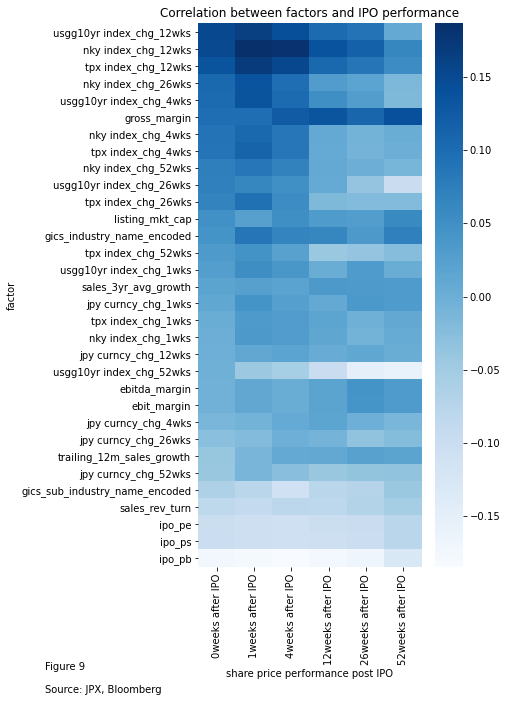

In [285]:
f, ax = plt.subplots(1, figsize=(5, 10))
sns.heatmap(corr_matrix, cmap='Blues', ax=ax)
ax.set(title="Correlation between factors and IPO performance", ylabel='factor', xlabel='share price performance post IPO')

f.text(-0.3,-0.05, "Figure 9\n\nSource: JPX, Bloomberg")
plt.show()

### 2.2 Predicting IPO performance

With the training data we can do some more interesting predictions now. Our dataset is quite small (467 IPOs) so we don't need to consider neural networks. We can try random forests, adaboost and bayesian classifier given the noisy nature of the data. To make the predictions a bit more meaningful, we are also going to bin the performance into categories so we don't have to worry about forecasting the actual performance.

In [332]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score

# train test split
horizon = 0

X = train_data.drop([f'target_{w}weeks' for w in (0, 1, 4, 12, 26, 52)], axis=1).select_dtypes('number')
y = train_data.loc[:, f"target_{horizon}weeks"]
X = X.loc[~y.isna()]
y = y.loc[~y.isna()]
y = pd.cut(y, bins=[float("-inf"), -0.2, 0.2, 1, float("+inf")])
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
imp = KNNImputer(n_neighbors=3)
smote = SMOTE(random_state=1)
X_train = X_train.replace(float("inf"), np.nan).replace(float("-inf"), np.nan)
X_train = imp.fit_transform(X_train)
X_train, y_train = smote.fit_resample(X_train, y_train)
sc = StandardScaler()

dtc = DecisionTreeClassifier(random_state=1, splitter="best", max_depth=5, criterion="entropy")

rf = RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=5, min_samples_leaf=15)
abc = AdaBoostClassifier(base_estimator=dtc, n_estimators=25, learning_rate=0.05)
nbc = GaussianNB(var_smoothing=1e-5)
rf_model = make_pipeline(imp, sc, rf)
abc_model = make_pipeline(imp, sc, abc)
nbc_model = make_pipeline(imp, sc, nbc)

In [289]:
def get_accuracy(model):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

After training the model we can check the accuracy score on the testing data set. 

Note that we have 4 classes we are trying to predict - return <-20%, -20% to 20%, 20% to 100%, and above 100%. This means that if we were to randomly guess, our success rate (accuracy) would be 25%, in reality it will be a slightly different as some classes are more common.

We can see that our AdaBoost model performs best, with an accuracy of 42%. We shouldn't push the accuracy too high, as that would cause overfitting (model looking at small details particular to the historical data but don't have predictive power) - our data set is small and there are a lot of noise, so this is about as good as we can do. IPO performance, as mentioned, have a large random component to it, as mentioned.

Our model performas as follows:

In [333]:
rf_model.fit(X=X_train, y=y_train)
abc_model.fit(X=X_train, y=y_train)
nbc_model.fit(X=X_train, y=y_train)

print(f"Accuracy:\nRandom Forest: {get_accuracy(rf_model):.2f}\nAdaBoost: {get_accuracy(abc_model):.2f}\nNaive Bayes: {get_accuracy(nbc_model):.2f}")

Accuracy:
Random Forest: 0.42
AdaBoost: 0.42
Naive Bayes: 0.28


In [131]:
# get confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def get_confusion_mt(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return cm

We can also check the confusion matrix of our model to see how it perform. The y axis represents the true class (of IPO performance), and the x axis prepresents the predicted classes.

A perfect model would have only the diagnal - all classes predicted correctly. Ours is not, but we can see it has reasonable performance.

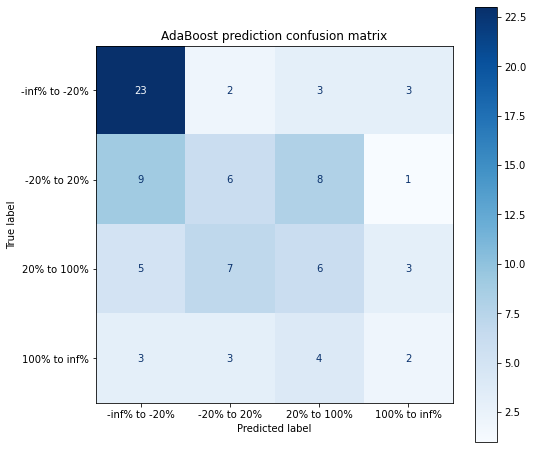

In [334]:
f, ax = plt.subplots(1, figsize=(8, 8))
ConfusionMatrixDisplay(get_confusion_mt(abc_model)).plot(cmap='Blues', ax=ax)
ax.set_xticklabels(labels=[f"{c.left*100:.0f}% to {c.right*100:.0f}%" for c in y_encoder.classes_])
ax.set_yticklabels(labels=[f"{c.left*100:.0f}% to {c.right*100:.0f}%" for c in y_encoder.classes_])
ax.set(title='AdaBoost prediction confusion matrix')
plt.show()

In [91]:
# hyper parameter tuning

from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=abc_model, X=X_train, y=y_train, 
                                         train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

In [157]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

Our random forest classifier is not as good, but it has an important use case - figuring the factor importances.

Slightly different from the correlation matrix, we can see that the most important feature included valuation, listing market cap, trailing index performance, and interest rates.

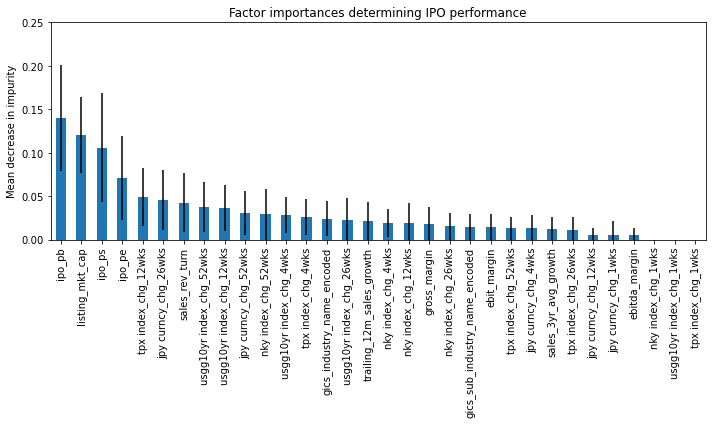

In [335]:
f, ax = plt.subplots(1, figsize=(10, 6))
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.named_steps['randomforestclassifier'].estimators_], axis=0) / 2
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
std = pd.Series(std, index=feature_names).reindex(forest_importances.index, fill_value=0)

forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Factor importances determining IPO performance")
ax.set_ylabel("Mean decrease in impurity")
ax.set(ylim=(0, 0.25))
f.tight_layout()

### Stock performance prediction

As I don't have the detailed financial information and potential listing price for this company, I can only assume a few scenarios based on similar companies. 

Globally listed portable power bank companies are actually quite rare, the most directably comparable company is [Smart Charge](https://www.enmonster.com/) (EM US, formerly known as EN Monster), a China based company which sales and rents portable chargers, listed in the US. Smart Charge operates predominantly in China. 

Below is a snap shop of its income statement (in millions):

In [368]:
import yahooquery as yq
em = yq.Ticker("EM")
em_is = em.income_statement()
display_df = em_is.T.loc[['asOfDate', 'periodType', 'currencyCode', 'TotalRevenue', 'GrossProfit', 
    'OperatingExpense', 'EBITDA', 'NormalizedEBITDA', 'EBIT', 'NetIncome']].applymap(lambda x: round(x/1e6, 1) if isinstance(x, float) else x)
display_df = display_df.T.set_index('asOfDate').T
display_df

asOfDate,2019-12-31,2020-12-31,2021-12-31,2021-12-31
periodType,12M,12M,12M,TTM
currencyCode,CNY,CNY,CNY,CNY
TotalRevenue,2022.3,2809.4,3585.4,3585.4
GrossProfit,1729.8,2378.6,3028.2,3028.2
OperatingExpense,1497.8,2246.8,3137.2,3137.2
EBITDA,NaN,NaN,NaN,310.3
NormalizedEBITDA,436.4,485.9,318.3,318.3
EBIT,239.4,134.6,-86.6,-86.6
NetIncome,166.6,75.4,-124.6,-124.6


Smart Charge been growing at ~40% annual since listing, and as a 85% gross margin / 10% EBITDA margin. I'm assuming similar financials for this portable charger company to be listed in Japan (target company). 

Below is the valuation metrics for Smart Charge. Its valuations have been depressed to a great extent due to a few reasons: 

1) shrinking margins; 

2) challenging environment in China with sluggish smartphone sales; 

3) regulatory pressure on the sector from the Chinese government; and 

4) uncertainties around potential delisting due to accounting/auditing debates between the US's PCAOB and China's CSRC. 

In [472]:
em_val = em.valuation_measures
em_val.EnterpriseValue = em_val.EnterpriseValue / 1e6
em_val.MarketCap = em_val.MarketCap / 1e6
em_val.round(1).fillna('')

,asOfDate,periodType,EnterpriseValue,EnterprisesValueEBITDARatio,EnterprisesValueRevenueRatio,MarketCap,PbRatio,PsRatio
symbol,,,,,,,,
EM,2021-06-30,3M,2092.5,102.3,2.2,1514.1,,2.9
EM,2021-09-30,3M,1410.9,-18.7,1.5,833.1,1.6,1.5
EM,2021-12-31,3M,950.8,-15.6,1.1,364.2,0.7,0.7
EM,2022-05-06,TTM,434.3,,,276.6,0.6,0.4
EM,2022-05-07,TTM,,1.4,0.1,,,


Smart Charge's share price (see chart below) has been performing miserably due to the aforementioned reasons. 

As our target company operates in Japan, it's unlikely going to see these pressure EM US sees, but the valuation should be lower than the multiples EM went public at. My base case takes reference from EM's valuation in mid-2021, before the regulatory pressure kicked in. 

We can plug in EM's financials and check a few scenarios for target company:

1) High valuation - ipo_ps = 20.0x; ipo_pe = -100.0x; ipo_pb = 10.0x; all still lower than the average valuation in the growth board.

2) Similar to EM valuation last year - ipo_ps = 4.0x; ipo_pe = -20.0x; ipo_pb = 2.0x;

3) Very low valuation similar to EM now - ipo_ps = 1.0x; ipo_pe = -5.0x; ipo_pb = 1.0x


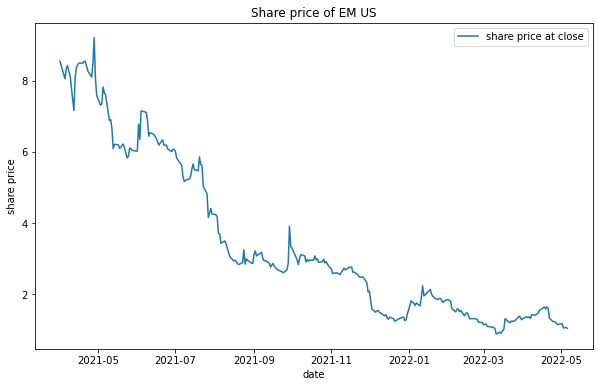

In [381]:
em_closepx = em.history(start=dt.date(2020, 1, 1), end=dt.date.today()).close
em_closepx.index = em_closepx.index.get_level_values(1)

f, ax = plt.subplots(1, figsize=(10, 6))
em_closepx.plot(ax=ax, label='share price at close')
ax.legend()
ax.set(title="Share price of EM US", ylabel='share price')
plt.show()

In [457]:
target_company = train_data.drop([f'target_{w}weeks' for w in (0, 1, 4, 12, 26, 52)], axis=1).select_dtypes('number').iloc[-1, :].to_frame().T

In [467]:
def plot_prediction_proba(additional_title_info: str='', models=[abc_model], target_company=target_company):
    f, ax = plt.subplots(1, figsize=(10, 6))
    x = [f"{i.left} to {i.right}" for i in y_encoder.classes_]
    xloc = list(range(len(x)))
    i = - len(models) * 0.5
    step = 0.5 / len(models)
    for model in models:
        ax.bar([k + i for k in xloc], height=model.predict_proba(target_company)[0], width=0.5 / len(models), 
            label=f"{list(model.named_steps.keys())[-1]} predictions")
        i += step
    ax.set_xticks([k - 2 * step * len(models) for k in xloc])
    ax.set_xticklabels(labels=x)
    ax.legend()
    ax.set(title=f"Predicted probability of IPO performance {additional_title_info}", ylabel="probabiility", xlabel="IPO performance")
    return f

Now let's look at what our high valuation case implicates. We assumt 10x p/s, -100x p/e, and 20x p/b in the base case, as see what the models predict.

In [462]:
target_company_high = target_company.copy(deep=True)
target_company_high.loc[:, ['ipo_pb', 'ipo_pe', 'ipo_ps']] = [20.0, -100.0, 10.0]
target_company_high.T.head(3)

,target company
,Electronic Equipment & Instrum
,This is the company we are trying to do prediction for
ipo_ps,10.0
ipo_pe,-100.0
ipo_pb,20.0


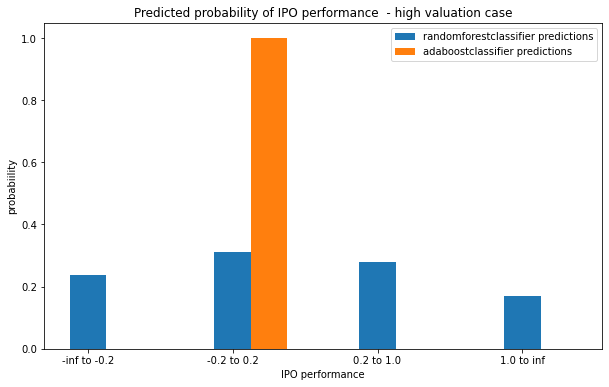

In [468]:
plot_prediction_proba(' - high valuation case', [rf_model, abc_model], target_company_high).show()

In the high valuation case, both random forest and adaboost models are predicting the -20% to 20% performance class (the chart means the adaboost is predicting 100% chance that the IPO will rise -20% to 20%, and randomforest is predicting about 35% chance that the IPO rise -20% to 20%). Both models agree, so the high valuation case is very likely goign to see -20% to 20% return on the IPO day, based on the historical data.

We can take a look at the base case also. 

In [463]:
target_company_base = target_company.copy(deep=True)
target_company_base.loc[:, ['ipo_pb', 'ipo_pe', 'ipo_ps']] = [4.0, -20.0, 2.0]
target_company_base.T.head(3)

,target company
,Electronic Equipment & Instrum
,This is the company we are trying to do prediction for
ipo_ps,2.0
ipo_pe,-20.0
ipo_pb,4.0


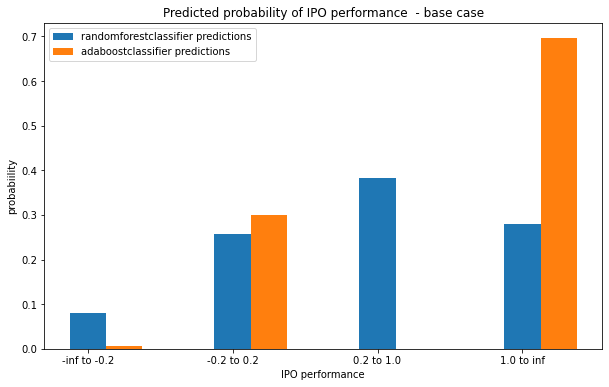

In [469]:
plot_prediction_proba(' - base case', [rf_model, abc_model], target_company_base).show()

In the base case where valuation is slightly higher than EM US but extremely cheap by growth board standards, the stock could perform well. Our models are prediction either 20-100% increase or even more than 100% increase at IPO. 

Finally, let's look at the bear/low valution case. 

In [470]:
target_company_low = target_company.copy(deep=True)
target_company_low.loc[:, ['ipo_pb', 'ipo_pe', 'ipo_ps']] = [1.0, -5.0, 1.0]
target_company_low.T.head(3)

,target company
,Electronic Equipment & Instrum
,This is the company we are trying to do prediction for
ipo_ps,1.0
ipo_pe,-5.0
ipo_pb,1.0


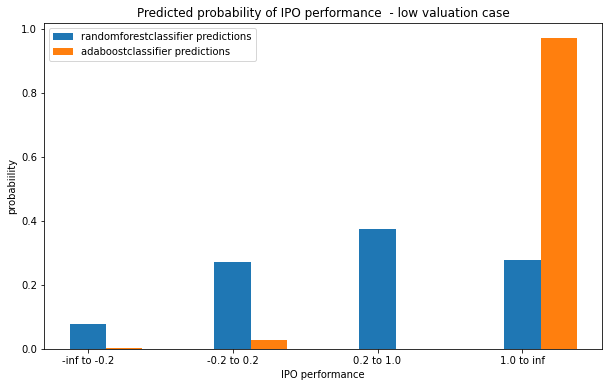

In [471]:
plot_prediction_proba(' - low valuation case', [rf_model, abc_model], target_company_low).show()

In the bear valuation case, both models are prediction high probability of very high returns. Intuitively this would make sense, as low valuation could revert to its true valuation if market is sufficiently efficient. 

## Conclusion

We have looked at the valuations and fundamental difference between growth board and the wider market, and noticed a wide valuation gap, with the growth board being generally very expensive with >100x P/E, ~40x P/S, and close to 10x P/B, all much more expensive than the overall market. It's also high growth and more volatile.

We then explored the IPO performance and know that IPOs on the growth board have on average been generating postive return since 2014, but in bear market years it's generally flat on IPO day. Return tend to ease off longer after the IPO and most IPOs drop to their offering prices after a year. 

We also explored the factors impacting IPO performance, and know that valuation at IPO, market performance, and interest rates are the most important factors affecting IPO performance.

For our target company itself, there are not many companies directly comparable so we could only look at EM US, which offers similar services. However, the idiosyncrasies of EM US from operating in China means that most of the metrics/performance cannot be directly applied to our target company. I have created 3 valuation scenarios with assumed financial that are similar to EM US, and have provided the predicted performance on the IPO day for each scenario. IPO performance tend to not differ too much from the IPO date within 6 months on average. 1 year after the IPO, however, expensive IPO almost always drop back and cheaper IPOs tend to revert to its true value.  

In [533]:
# export to PDF
import subprocess
subprocess.call('./makepdf.zsh', shell=True)

126

In [ ]:
!jupyter-nbconvert jpx_analysis.ipynb --no-input --no-prompt --to html

In [ ]:
!jupyter-nbconvert jpx_analysis.ipynb --no-input --no-prompt --to markdown

In [ ]:
!jupyter-nbconvert jpx_analysis.ipynb --no-input --no-prompt --to pdfviahtml